# CNN Project
We'll be using the CIFAR-10 dataset, which is very famous dataset for image recognition!

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. 
There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 10000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.



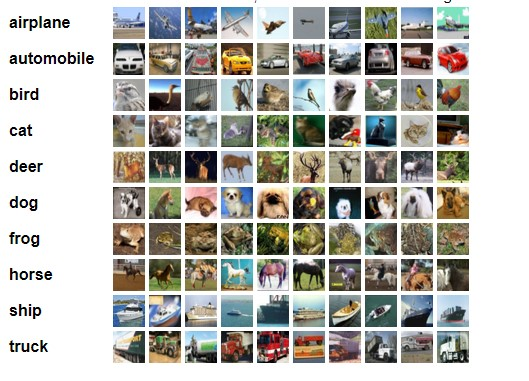

## Data  Processing 

** Download the data for CIFAR from here: https://www.cs.toronto.edu/~kriz/cifar.html **

*Specifically the CIFAR-10 python version link: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz *

In [1]:
data_dir='cifar-10-data/'   # Data directory where all data_batch the files contain
files = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [2]:
# Unpickle function is provided with the data
def unpickle(file):                                    
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [3]:
all_data=list(range(0,7))


In [4]:
for i,direc in zip(all_data,files):
    all_data[i] = unpickle(data_dir+direc)

In [5]:
data_meta = all_data[0]
data_1 = all_data[1]
data_2 = all_data[2]
data_3 = all_data[3]
data_4 = all_data[4]
data_5 = all_data[5]
test_batch = all_data[6]

In [6]:
# Total Labels Present in the Data (n =10)
data_meta[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [7]:
data_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [8]:
''' 

The images are stored in row major order
As all the images are Colour Images RGB 
Each channel of the image is stored one after another for example:
    In row 1 first 32*32(1024) values represent the red channel and the further 32*32(1024) values represent green channel and then 32*32(1024) values represent blue
    We can interpret it as :
   [img 1]      row 1        0-1023(R channel) 1024-2047(G channel) 2048 -3071(Blue channel)
   [img 1]      row 2        0-1023(R channel) 1024-2047(G channel) 2048 -3071(Blue channel)
   ...
   ...
   ...
   [img 10000 ] row 100000   0-1023(R channel) 1024-2047(G channel) 2048 -3071(Blue channel)
   
   
'''

# Size of the data :
data_1[b'data'].shape

(10000, 3072)

In [9]:
data_1[b'data']

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [11]:
img = data_1[b'data']
img = img.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")  # reshape(total images, no of channel, height , width )

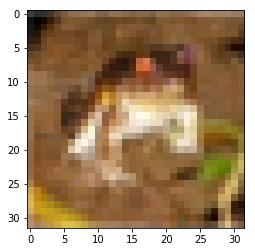

In [12]:
plt.imshow(img[0])

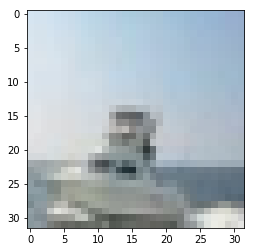

In [13]:
plt.imshow(img[100])

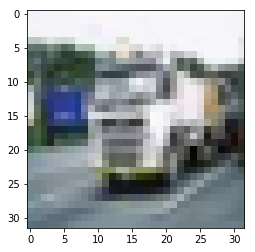

In [14]:
plt.imshow(img[1000])

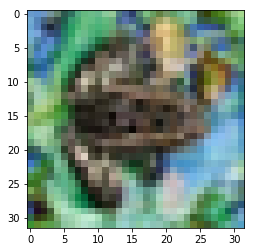

In [15]:
plt.imshow(img[200])

In [16]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [76]:
class DataSet():
    def __init__(self):
        self.i = 0
        self.all_train_batches = [data_1,data_2,data_3,data_4,data_5]  # all the train data batches
        self.test_batch = [test_batch]  # test data batches
        # Training Data
        self.train_images = None
        self.train_labels = None
        # Test data
        self.test_images = None
        self.test_labels = None
        
    def set_data(self):
            
            
        self.train_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.train_images)
         # Reshapes and normalizes train images
        self.train_images = self.train_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes 
        self.train_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes 
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)
    
    def next_batch(self, batch_size):
        x = self.train_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.train_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.train_images)
        return x, y

## Creating the CNN model

In [77]:
import tensorflow as tf 
from tensorflow.nn import max_pool
from tensorflow.nn import conv2d
from tensorflow.nn import relu
from tensorflow.nn import dropout
from tensorflow.nn import softmax_cross_entropy_with_logits as SM
from tensorflow.train import AdamOptimizer as Adam

In [78]:
x = tf.placeholder(tf.float32,shape=[None,32,32,3])

In [79]:
y_true = tf.placeholder(tf.float32,shape=[None,10])

In [80]:
y_prob = tf.placeholder(tf.float32)

In [81]:
# Required funstions :
def init_weights(shape):          # For weight Initialization
    init_random_dist = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):           # For bias initialization
    init_bias_val = tf.constant(0.1,shape=shape)
    return tf.Variable(init_bias_val)


In [92]:
# Layer functions 
def max_pool_2x2(x):
    # x --> [batch,H,W,Channels]
    layer = max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    return layer
def conv_2d(x, W):
    return conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def conv_layer(input_x,shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    layer = relu(conv_2d(input_x,W) +b)
    return layer

def dense_layer(input_layer,size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b


In [93]:
# Creating layers:
conv_1 = conv_layer(x,shape=[4,4,3,32])   # 1 convolutional layer
conv_1_pool = max_pool_2x2(conv_1)

In [94]:
conv_2 = conv_layer(conv_1_pool,shape=[4,4,32,64]) # 2 convolutional layer
conv_2_pool = max_pool_2x2(conv_2)

In [95]:
conv_2_flat = tf.reshape(conv_2_pool,[-1,8*8*64])  # 1 Dense layer
full_layer_1 = relu(dense_layer(conv_2_flat,1024))

In [96]:
dropout_1= dropout(full_layer_1,keep_prob= y_prob) # 1 Dropout  layer


In [97]:
y_pred = dense_layer(dropout_1,10)

In [98]:
Loss = tf.reduce_mean(SM(labels = y_true,logits=y_pred)) #Loss Function

In [99]:
optimizer= Adam(learning_rate=0.001) # Optimizer
train = optimizer.minimize(Loss)

In [100]:
init = tf.global_variables_initializer()
ds = DataSet()
ds.set_data()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [105]:
saver = tf.train.Saver()


In [106]:
epochs = 1000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(epochs):
        batch = ds.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], y_prob: 0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on Epoch {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            print(sess.run(acc,feed_dict={x:ds.test_images,y_true:ds.test_labels,y_prob:1.0}))
            print('\n')
    saver.save(sess,'models/cifar-10-cnn.ckpt')        
    

Currently on Epoch 0
Accuracy is:
0.0897


Currently on Epoch 100
Accuracy is:
0.4157


Currently on Epoch 200
Accuracy is:
0.4586


Currently on Epoch 300
Accuracy is:
0.491


Currently on Epoch 400
Accuracy is:
0.5168


Currently on Epoch 500
Accuracy is:
0.5047


Currently on Epoch 600
Accuracy is:
0.5332


Currently on Epoch 700
Accuracy is:
0.569


Currently on Epoch 800
Accuracy is:
0.5767


Currently on Epoch 900
Accuracy is:
0.5773




In [110]:
import cv2
im = cv2.imread("test1.jpg")
print(type(im))
    

<class 'numpy.ndarray'>


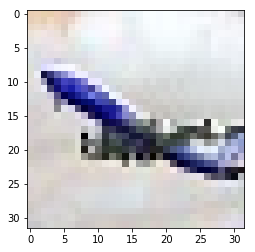

In [133]:
plt.imshow(im)
image = np.array(im, dtype=np.uint8)
image1 = image.reshape(1,32,32,3)

In [145]:
with tf.Session() as sess:
    saver.restore(sess,'models/cifar-10-cnn.ckpt')
    y1 = tf.constant(0,shape=[0,10])
    y_p = tf.Variable(y1)
    sess.run(y_pred,feed_dict = {x:image1,y_true:y_p})
    

INFO:tensorflow:Restoring parameters from models/cifar-10-cnn.ckpt


ValueError: setting an array element with a sequence.